In [1]:
import optuna
import joblib
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


C:\Users\Tomasovi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load data
Data = pd.read_csv('diabetes_prediction_dataset.csv')
print(Data.head())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [3]:

# Check for NULL values in the dataset
null_values = Data.isnull().sum()

# Print columns with NULL values
print("Columns with NULL values:")
print(null_values[null_values > 0])

Columns with NULL values:
Series([], dtype: int64)


In [4]:
# Data preprocessing
numeric_columns = Data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
Data[numeric_columns] = scaler.fit_transform(Data[numeric_columns])
Data = pd.get_dummies(Data, drop_first=True)

# Ensure all data is numeric and handle missing values
Data = Data.apply(pd.to_numeric, errors='coerce')
Data = Data.fillna(0)  # Fill missing values with 0 or use another strategy

# Convert boolean columns to integers
bool_columns = Data.select_dtypes(include=['bool']).columns
Data[bool_columns] = Data[bool_columns].astype(int)

# Define target and features
target = 'diabetes'
features = Data.drop(columns=[target]).columns

# Normalize the target variable
Data[target] = Data[target].astype(float)

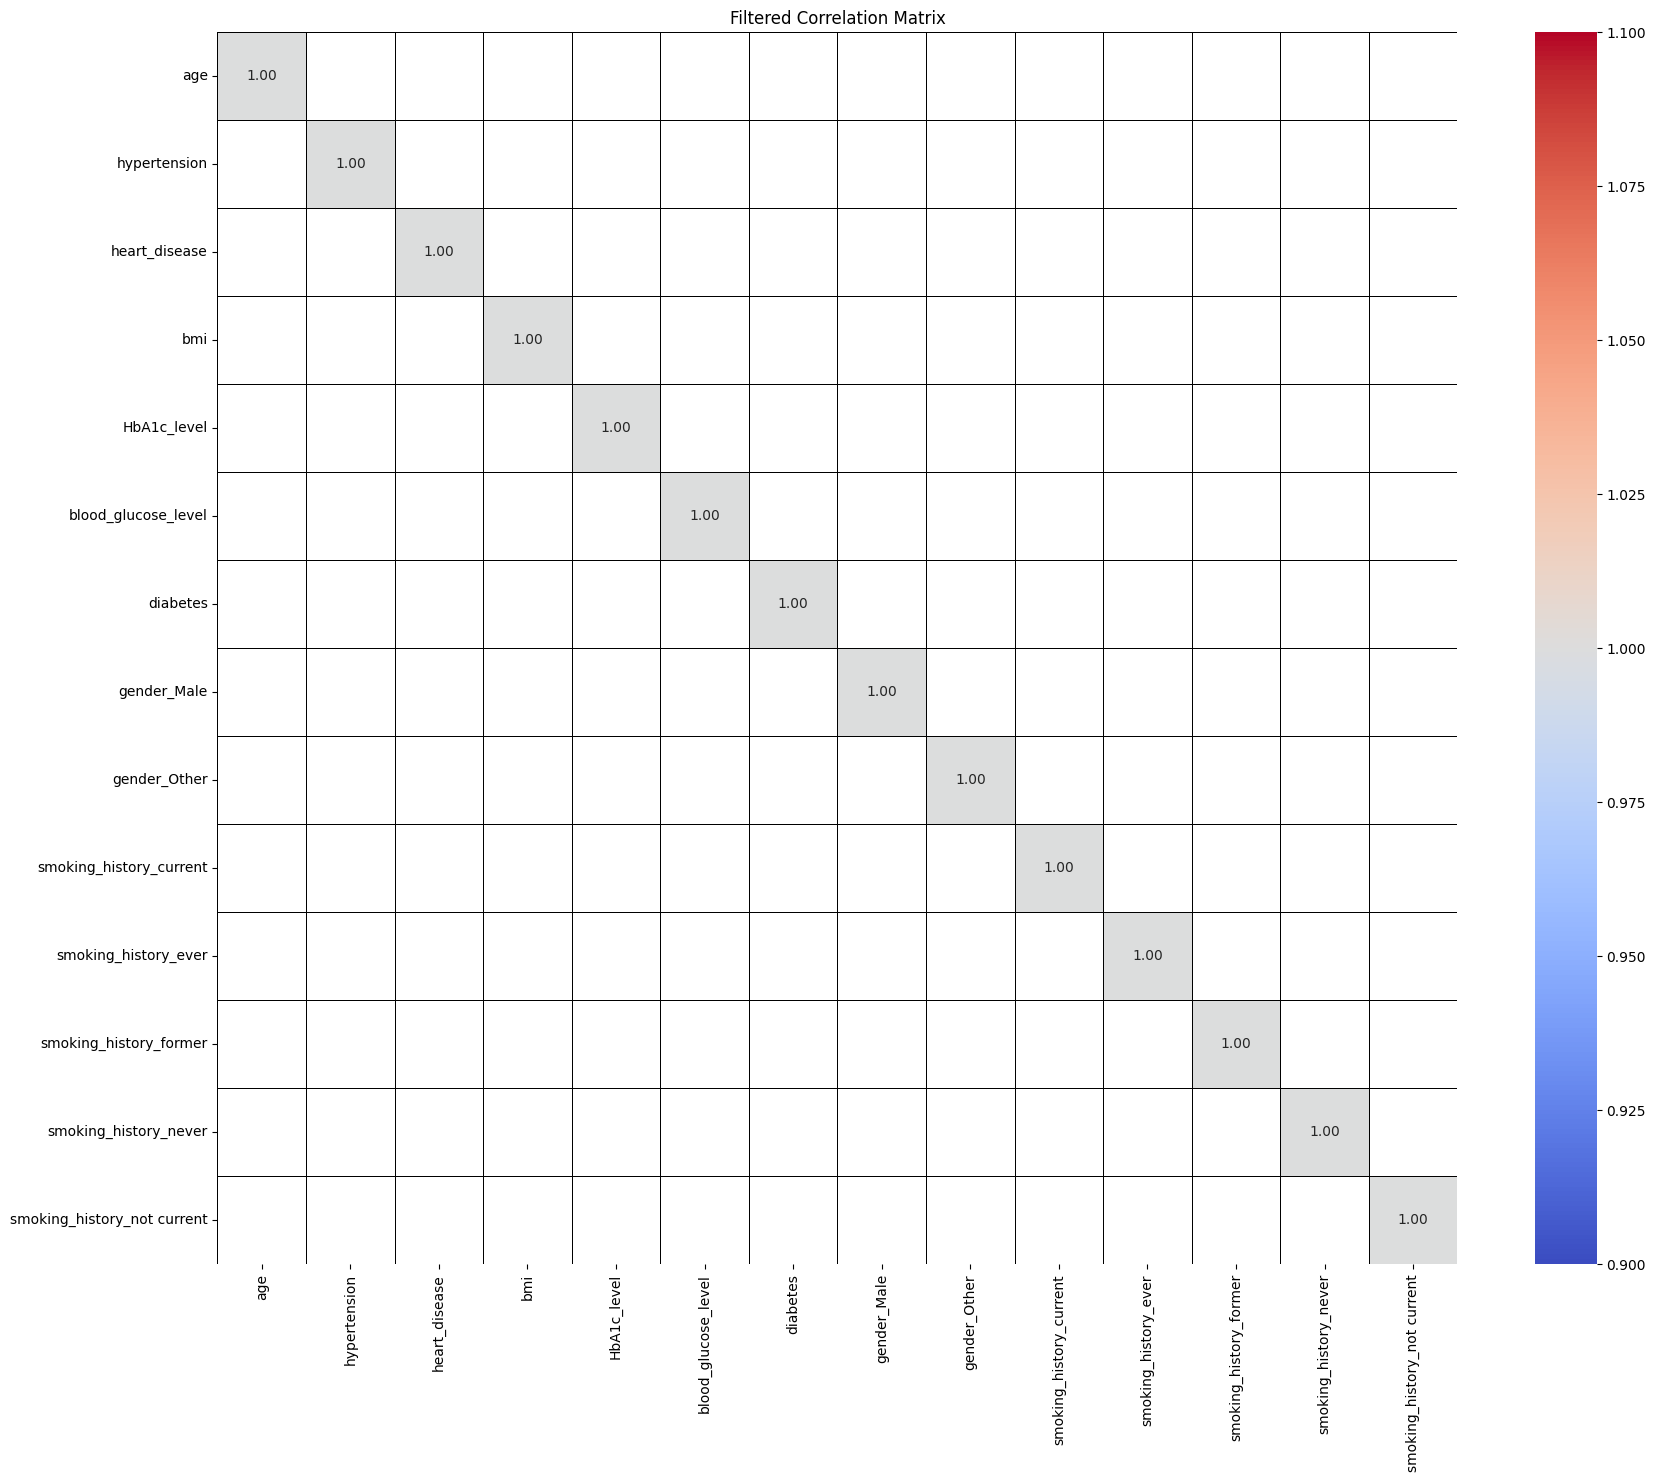

In [5]:
# Compute the correlation matrix
correlation_matrix = Data.corr()

# Set a threshold for significant correlations
threshold = 0.7

# Filter the correlation matrix
filtered_corr_matrix = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Filtered Correlation Matrix')
plt.show()

In [6]:
# Identify highly correlated features
high_corr_pairs = [(col1, col2) for col1 in filtered_corr_matrix.columns for col2 in filtered_corr_matrix.columns if col1 != col2 and abs(filtered_corr_matrix.loc[col1, col2]) > threshold]

# Print highly correlated pairs
print("Highly correlated pairs:")
for pair in high_corr_pairs:
    print(pair, filtered_corr_matrix.loc[pair[0], pair[1]])

# Remove one feature from each highly correlated pair
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    # Example: Remove the second feature in each pair
    features_to_remove.add(col2)

# Drop the selected features from the dataset
Data_reduced = Data.drop(columns=features_to_remove)

Highly correlated pairs:


In [7]:
# Define target and features
X = Data[features]
y = Data[target]
y = y.astype(str)  # Convert to string categories

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Compute permutation importance
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_importance_df)

                        Feature  Importance
4                   HbA1c_level    0.080304
5           blood_glucose_level    0.068913
0                           age    0.026769
3                           bmi    0.025769
6                   gender_Male    0.013248
11        smoking_history_never    0.011076
1                  hypertension    0.007762
10       smoking_history_former    0.006319
2                 heart_disease    0.004861
8       smoking_history_current    0.003502
12  smoking_history_not current    0.002803
9          smoking_history_ever    0.002033
7                  gender_Other    0.000000


In [8]:
# Drop columns where importance is below specific value
low_importance_features = perm_importance_df[perm_importance_df['Importance'] < 0.02]['Feature']
Data = Data.drop(columns=low_importance_features)

# Update features after dropping low-importance columns
features = Data.drop(columns=[target]).columns

# Show the updated list of features
print("Updated list of features:")
print(Data.columns)

X = Data[features]
y = Data[target]
y = y.astype(str)  # Convert to string categories

Updated list of features:
Index(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'], dtype='object')


In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
    }
    
    model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)  # Maximize accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f'Best parameters: {study.best_params}')

[I 2025-03-28 09:05:28,728] A new study created in memory with name: no-name-381e9d64-c019-4dcd-940d-a7103e90c890
[I 2025-03-28 09:06:03,224] Trial 0 finished with value: 0.97165 and parameters: {'n_estimators': 920, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 0.6829138458544459}. Best is trial 0 with value: 0.97165.
[I 2025-03-28 09:06:41,903] Trial 1 finished with value: 0.9711 and parameters: {'n_estimators': 697, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.8920325658970929}. Best is trial 0 with value: 0.97165.
[I 2025-03-28 09:06:55,661] Trial 2 finished with value: 0.97205 and parameters: {'n_estimators': 311, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.921838982240964}. Best is trial 2 with value: 0.97205.
[I 2025-03-28 09:07:34,844] Trial 3 finished with value: 0.972 and parameters: {'n_estimators': 903, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 9, '

Best parameters: {'n_estimators': 315, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 0.8656762762747625}


In [10]:
# Use the best parameters from the Optuna study
best_params = study.best_params

# Initialize the XGBRegressor with the best parameters
model = RandomForestClassifier(**best_params, random_state=42)

# Train the model on the full training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_val)

# Evaluate the model
acc = accuracy_score(y_val, preds)

print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9721


In [11]:
# Save both the scaler and the model in one file
joblib.dump({'model': model, 'scaler': scaler}, 'Diabetes_Prediction_Model.pkl')

['Diabetes_Prediction_Model.pkl']

In [ ]:
import joblib
import pandas as pd

# Load the saved model and scaler
loaded_objects = joblib.load('Diabetes_Prediction_Model.pkl')
model = loaded_objects['model']
scaler = loaded_objects['scaler']

"""
Feature  Importance
HbA1c_level             0.080304
blood_glucose_level     0.068913
age                     0.026769
bmi                     0.025769
"""

# Example new data (without scaling)
new_data = pd.DataFrame([{
    'gender': 'Male',  # Unused column
    'age': 30,
    'hypertension': 0,  # Unused column
    'heart_disease': 0,  # Unused column
    'bmi': 20.5,
    'HbA1c_level': 6,
    'blood_glucose_level': 30,
    'diabetes': 0,  # Unused column
}])

# Keep only the relevant columns used in training
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
new_data = new_data[features]
# Scale the input using the same scaler used during training
new_data_scaled = scaler.transform(new_data)
new_data_scaled = pd.DataFrame(new_data_scaled, columns=new_data.columns)
new_data_scaled = new_data_scaled.drop(columns=['hypertension', 'heart_disease', 'diabetes'])

# Make the prediction
prediction_proba = model.predict_proba(new_data_scaled)
print("Probability of Diabetes (1):", prediction_proba[0][1])

Probability of Diabetes (1): 0.0012503326167041082
